<a href="https://colab.research.google.com/github/repairedserver/Test/blob/master/Class_Activation_Map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
cd/content/gdrive/My Drive/deeplearningbro/deeplearningbro/pytorch

/content/gdrive/My Drive/deeplearningbro/deeplearningbro/pytorch


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
transform = transforms.Compose([transforms.Resize(128), transforms.ToTensor()])
trainset = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=transform) # 96x96
trainloader = torch.utils.data.DataLoader(trainset, batch_size=40, shuffle=True)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data


In [7]:
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-2)

In [9]:
for epoch in range(20):
  running_loss = 0.0
  for data in trainloader:
    inputs, labels = data[0].to(device), data[1].to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
  
  cost = running_loss / len(trainloader)
  print('[%d] loss : %.3f' %(epoch+1, cost))

torch.save(model.state_dict(), './stl10_resnet18.pth')
print('end')

[1] loss : 0.584
[2] loss : 0.101
[3] loss : 0.035
[4] loss : 0.025
[5] loss : 0.115
[6] loss : 0.141
[7] loss : 0.082
[8] loss : 0.042
[9] loss : 0.035
[10] loss : 0.097
[11] loss : 0.098
[12] loss : 0.064
[13] loss : 0.047
[14] loss : 0.055
[15] loss : 0.053
[16] loss : 0.051
[17] loss : 0.074
[18] loss : 0.071
[19] loss : 0.075
[20] loss : 0.057
end


In [10]:
correct = 0
total = 0
with torch.no_grad():
  for data in trainloader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

In [11]:
print("%d %%"%(100*correct / total))

97 %


In [12]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
activation = {}
def get_activation(name):
  def hook(model, input, output):
    activation[name] = output.detach()
  return hook

In [14]:
def cam(model, trainset, img_sample, img_size):
  model.eval()
  with torch.no_grad():

    model.layer4[1].bn2.register_forward_hook(get_activation('final'))
    data, label = trainset[img_sample]
    data.unsqueeze_(0)
    _ = model(data.to(device))
    act = activation['final'].squeeze()
    w = model.fc.weight

    for idx in range(act.size(0)):
      if idx == 0:
        tmp = act[idx] * w[label][idx]
      else:
        tmp += act[idx] * w[label][idx]
      
      normalized_cam = tmp.cpu().numpy()
      normalized_cam = (normalized_cam - np.min(normalized_cam)) / (np.max(normalized_cam) - np.min(normalized_cam))
      cam_img = cv2.resize(np.uint8(normalized_cam*255), dsize=(img_size, img_size))
      original_img = np.uint8((data[0][0] / 2 + 0.5) * 255)
    return cam_img, original_img

In [16]:
def plot_cam(model, trainset, img_size, start):
  end = start + 20
  fig, axs = plt.subplots(2, (end - start + 1) // 2, figsize=(20, 5))
  fig.subplots_adjust(hspace=.01, wspace=.01)
  axs = axs.ravel()

  for i in range(start, end):
    cam_img, original_img = cam(model, trainset, i, img_size)
    axs[i - start].imshow(original_img, cmap='gray')
    axs[i - start].imshow(cam_img, cmap='jet', alpha=.5)
    axs[i - start].axis('off')
  
  plt.show()
  fig.savefig('cam.png')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


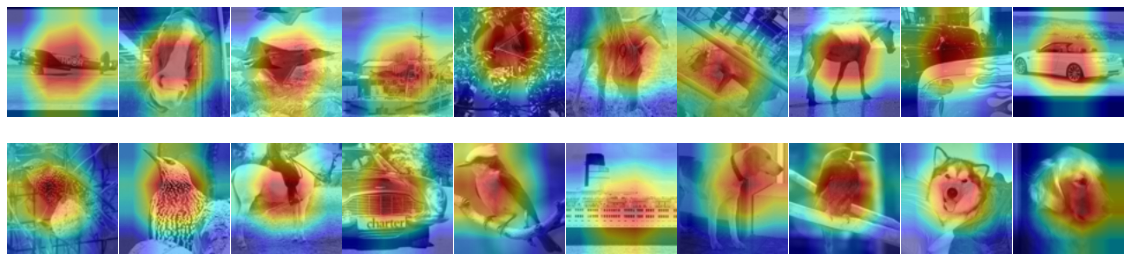

In [17]:
plot_cam(model,trainset,128,10)